# Ch5 Categorizing and Tagging Words

本章的目標是回答這些問題:

1. 什麼是lexical categories? 它們如何應用在NLP中?
2. 要儲存單字和分類的資料結構是什麼?
3. 如何自動為每個單字分類?

本章會提到一些基本的NLP方法，例如sequence labeling、n-gram models、backoff、evaluation。

辨識單字的part-of-speech(詞性)並標記的過程稱為tagging，或稱part-of-speech tagging、POS tagging。在一般的NLP流程中，tagging是接在tokenization後面。part-of-speech又稱為word class或lexical category。而可供選擇的tag集合稱為tagset。


## Using a Tagger

In [2]:
import nltk
text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

上面的範例中，CC是對等連接詞、RB是副詞、IN是介系詞、NN是名詞、JJ則是形容詞。如果想知道詳細的tag定義，可以用`nltk.help.upenn_tagset('RB')`來查詢。

## Tagged Corpora

在NLTK的習慣上，tagged token會表示成由單字和tag結合的tuple，但是儲存在corpus中的資料，則是一個字串包含單字和tag，中間以`'/'`分隔，例如`'fly/NN'`。利用`str2tuple`可以從corpus中的字串轉成tuple。

In [3]:
nltk.tag.str2tuple('fly/NN')

('fly', 'NN')

In [9]:
# tagged_words() 是一個已經表示成tuple形態的資料
nltk.corpus.brown.tagged_words()

[(u'The', u'AT'), (u'Fulton', u'NP-TL'), ...]

In [12]:
# 用參數 tagset='universal' 可以換成簡單的tag
nltk.corpus.brown.tagged_words(tagset='universal')

[(u'The', u'DET'), (u'Fulton', u'NOUN'), ...]

In [15]:
# 利用 FreqDist 統計詞性的數量
tag_fd = nltk.FreqDist(tag for (word, tag) in nltk.corpus.brown.tagged_words(tagset='universal'))
tag_fd.most_common()

[(u'NOUN', 275244),
 (u'VERB', 182750),
 (u'.', 147565),
 (u'ADP', 144766),
 (u'DET', 137019),
 (u'ADJ', 83721),
 (u'ADV', 56239),
 (u'PRON', 49334),
 (u'CONJ', 38151),
 (u'PRT', 29829),
 (u'NUM', 14874),
 (u'X', 1700)]

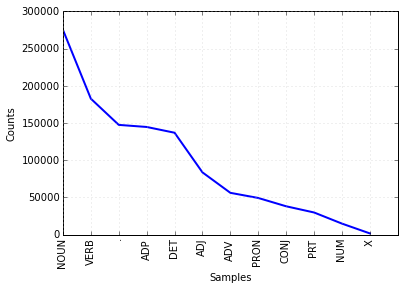

In [17]:
%matplotlib inline
tag_fd.plot()

In [61]:
tag_cd = nltk.ConditionalFreqDist(nltk.corpus.brown.tagged_words(tagset='universal'))

In [65]:
# 查詢某單字的常用POS
tag_cd['yield']

Counter({u'NOUN': 19, u'VERB': 16})

corpus中也有tagged sentences:

In [69]:
nltk.corpus.brown.tagged_sents(tagset='universal')[0]

[(u'The', u'DET'),
 (u'Fulton', u'NOUN'),
 (u'County', u'NOUN'),
 (u'Grand', u'ADJ'),
 (u'Jury', u'NOUN'),
 (u'said', u'VERB'),
 (u'Friday', u'NOUN'),
 (u'an', u'DET'),
 (u'investigation', u'NOUN'),
 (u'of', u'ADP'),
 (u"Atlanta's", u'NOUN'),
 (u'recent', u'ADJ'),
 (u'primary', u'NOUN'),
 (u'election', u'NOUN'),
 (u'produced', u'VERB'),
 (u'``', u'.'),
 (u'no', u'DET'),
 (u'evidence', u'NOUN'),
 (u"''", u'.'),
 (u'that', u'ADP'),
 (u'any', u'DET'),
 (u'irregularities', u'NOUN'),
 (u'took', u'VERB'),
 (u'place', u'NOUN'),
 (u'.', u'.')]

## Mapping Words to Properties

要儲存mapping資料，最自然的方法就是用dictionary，又稱為associative array或hash array。一般的陣列是用整數作為index，但dictionary中則是用任何hasable的資料作為index，例如字串、tuple等等。

mapping資料的應用有:

1. 書的index: 將單字mapping到頁數
2. thesaurus: 將字義mapping到一組同義字
3. 字典: 將單字mapping到單字的解釋
4. 比較字集: 將單字mapping到多國語言的單字

In [72]:
pos = {}  # 在python中定義dictionary最簡單的方法
pos['hello'] = 'world'
pos['right'] = 'here'
pos

{'hello': 'world', 'right': 'here'}

In [74]:
[w for w in pos]  # 用for的時候會找出key

['right', 'hello']

In [75]:
pos.keys()

['right', 'hello']

In [76]:
pos.items()

[('right', 'here'), ('hello', 'world')]

In [77]:
pos.values()

['here', 'world']

In [80]:
pos = dict(hello = 'world', right = 'here')  # 另一種定義方式
pos

{'hello': 'world', 'right': 'here'}

### Default Dictionary

如果試著存取不存在的key，會造成錯誤。`defaultdict`可以使存取不存在的key時，自動新增一個預設值。

In [81]:
f = nltk.defaultdict(int)
f['color'] = 4
f

defaultdict(int, {'color': 4})

In [84]:
f['dream']  # dream不存在，但查詢時會自動新增

0

In [85]:
f  # 查詢dream後，就直接新增了一個dream

defaultdict(int, {'color': 4, 'dream': 0})

In [86]:
f = nltk.defaultdict(lambda: 'xxx')
f['hello'] = 'world'
f

defaultdict(<function __main__.<lambda>>, {'hello': 'world'})

In [87]:
f['here'] = f['here'] + 'comment'
f

defaultdict(<function __main__.<lambda>>,
            {'hello': 'world', 'here': 'xxxcomment'})

### Inverting a Dictionary

dict的設計是用key來查詢value，如果你希望用value來查詢key，速度會很慢。一種簡單的解法是用`(value,key)`重新產生一個`dict`，就可以用value查詢key。

In [6]:
old = dict(nltk.corpus.brown.tagged_words()[:100])
new = dict((value, key) for (key, value) in old.items())

In [8]:
new['JJ']  # 雖然成功的反相，但只能查出最後輸入的字

u'hard-fought'

In [10]:
new2 = nltk.defaultdict(list)  # 當key不存在時，都視為empty list
for (key, value) in old.items():
    new2[value].append(key)

In [11]:
new2['JJ']

[u'over-all', u'possible', u'recent', u'hard-fought']

更簡單的方法: 利用nltk內建的函式。

In [12]:
new3 = nltk.Index((value, key) for (key, value) in old.items())
new3['JJ']

[u'over-all', u'possible', u'recent', u'hard-fought']

### Summary Dictionary Methods

* `d = {}`: 建立空的dict
* `d[key] = value`: 為key指定新的value
* `d.keys()`: 傳回list of keys
* `list(d)`: 傳回list of keys
* `d.values()`: 傳回list of values
* `sorted(d)`: 傳回sorted list of keys
* `key in d`: 如果d有包含key則傳回True
* `for key in d`: 依序傳回每一個Key
* `d1.update(d2)`: 將d2的每個item複製到d1
* `defaultdict(int)`: 預設value為0的dict
* `defaultdict(list)`: 預設value為`[]`的dict


## Automatic Tagging

In [13]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

### Default Tagger

第一步，先準備一個預設的tagger，統計所有part-of-speech中，那一種詞性出現頻率最高，就視為預設值。

In [14]:
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
nltk.FreqDist(tags).max()

u'NN'

In [15]:
default_tagger = nltk.DefaultTagger('NN')  # 因為NN頻率最高，所以未知詞性的情況一律當成NN
default_tagger.tag(nltk.word_tokenize('i like my mother and dog'))

[('i', 'NN'),
 ('like', 'NN'),
 ('my', 'NN'),
 ('mother', 'NN'),
 ('and', 'NN'),
 ('dog', 'NN')]

In [17]:
# 當然預測的準確率很差，因為只有13%是真的NN
default_tagger.evaluate(brown_tagged_sents)

0.13089484257215028

### Regular Expression Tagger

用經驗判斷那些字尾可能是什麼詞性，然後用regular expression寫成條件。

In [19]:
patterns = [
    (r'.*ing$', 'VBG'),
    (r'.*ed$', 'VBD'),
    (r'.*es$', 'VBZ'),
    (r'.*ould$', 'MD'),
    (r'.*\'s$', 'NN$'),
    (r'.*s$', 'NNS'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),
    (r'.*', 'NN')
]

In [22]:
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.tag(nltk.word_tokenize('i could be sleeping in 9 AM'))

[('i', 'NN'),
 ('could', 'MD'),
 ('be', 'NN'),
 ('sleeping', 'VBG'),
 ('in', 'NN'),
 ('9', 'CD'),
 ('AM', 'NN')]

In [23]:
regexp_tagger.evaluate(brown_tagged_sents)

0.20326391789486245

### Unigram Tagger

In [25]:
unigram_tagger = nltk.UnigramTagger(brown.tagged_sents(categories='news')[:500])

In [26]:
unigram_tagger.tag(nltk.word_tokenize('i could be sleeping in 9 AM'))

[('i', None),
 ('could', u'MD'),
 ('be', u'BE'),
 ('sleeping', None),
 ('in', u'IN'),
 ('9', u'CD-HL'),
 ('AM', None)]

unigram tagger是統計每個字最常出現的詞性，因此訓練資料越大，就會越準確。但遇到沒看過的字，就會傳回None。因此需要設**backoff**，當unigram tagger無法判斷時，用另一個tagger來輔助。

In [32]:
unigram_tagger = nltk.UnigramTagger(brown.tagged_sents(categories='news')[:500],
                                   backoff = regexp_tagger)

In [33]:
unigram_tagger.evaluate(brown_tagged_sents[500:])

0.7642357867248968

In [38]:
unigram_tagger = nltk.UnigramTagger(brown.tagged_sents(categories='news')[:4000],
                                   backoff = regexp_tagger)

In [40]:
unigram_tagger.evaluate(brown_tagged_sents[4000:])

0.8557620260752286

兩個重點:

1. 隨著training data增加，準確率也有提升，利用unigram最高可以到90%左右
2. 記得將training/testing data分開，否則準確率是不準的

### Bigram Tagger

統計兩個單字組成的bigram來作tagger。precision較高，但recall很低，一旦遇到不認識的字就馬上出現None。

In [41]:
bigram_tagger = nltk.BigramTagger(brown.tagged_sents(categories='news')[:4000])

In [42]:
bigram_tagger.tag(nltk.word_tokenize('i could be sleeping in 9 AM'))

[('i', None),
 ('could', None),
 ('be', None),
 ('sleeping', None),
 ('in', None),
 ('9', None),
 ('AM', None)]

In [43]:
bigram_tagger = nltk.BigramTagger(brown.tagged_sents(categories='news')[:4000],
                                 backoff=unigram_tagger)

In [44]:
bigram_tagger.evaluate(brown_tagged_sents[4000:])

0.8651281282781358

### Storing Taggers

因為training tagger很花時間，所以儲存結果是必要的。利用`cPickle.dump`來寫出binary格式的物件

In [46]:
from cPickle import dump
output = open('t2.pkl', 'wb')
dump(bigram_tagger, output, -1)
output.close()

In [47]:
from cPickle import load
input = open('t2.pkl', 'rb')
tagger = load(input)
input.close()

In [48]:
tagger.evaluate(brown_tagged_sents[4000:])

0.8651281282781358

### Confusion Matrix

In [55]:
brown_sents = brown.sents()
brown_tagged_sents = brown.tagged_sents(tagset = 'universal')
default_tagger = nltk.DefaultTagger('NOUN')
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents[:4000], backoff=default_tagger)
bigram_tagger = nltk.BigramTagger(brown_tagged_sents[:4000], backoff=unigram_tagger)

In [65]:
unigram_tagger.tag(nltk.word_tokenize('I like your mother'))

[('I', u'PRON'), ('like', u'ADP'), ('your', u'DET'), ('mother', u'NOUN')]

In [66]:
test = [tag for sent in brown_sents[4000:] for (word, tag) in bigram_tagger.tag(sent)]
gold = [tag for sent in brown_tagged_sents[4000:] for (word, tag) in sent]
print nltk.ConfusionMatrix(gold, test)

     |                                  C             N             P             V        |
     |             A      A      A      O      D      O      N      R      P      E        |
     |             D      D      D      N      E      U      U      O      R      R        |
     |      .      J      P      V      J      T      N      M      N      T      B      X |
-----+-------------------------------------------------------------------------------------+
   . |<137477>     .      .      .      .      .      4      .      .      .      .      . |
 ADJ |      . <52139>    88   2054      .      .  23140      .      .     50    436     57 |
 ADP |     20     82<121175>  1156    140    293    738      1     34  10315    109      . |
 ADV |      .   3132   2787 <40434>    69    288   6039      .      .    639     55      . |
CONJ |      .      .     37    130 <35585>    25     38      .      .      .      .      . |
 DET |      .      .   1103     29     80<125725>   122      2     29 

## How to Determine the Category of a Word

**Morphological Clues**

利用對形態學的知識，建立規則來判斷。例如ness結尾的可能是名詞、ment結尾的也可能是名詞。

**Syntactic Clues**

利用語法知識來判斷，出現在名詞前面和be動詞後面的，可能是形容詞。